# Generate a Phi+ Bell state conditional on a good CHSH Score

Let's say you need to run a simple circuit that creates and measures a Phi+ Bell state. 

You realize that for such a circuit, the computer's capability to entanglement is paramount. So, you to run your Phi+ circuit only if (conditional on)  the computer can generate a CHSH score that is close (e.g., 90%) to the ideal Tsirelson’s bound (~2.82).

Let's go step by step. We will explore:

1. Prepare our Phi+ circuit (nothing special about this).
2. Create a function that will run our circuit on a backend if it (the backend) can get to a CHSH score over a certain threshold.
3. Create a function that will do something else if the backend cannot get a CHSH score over the threshold. 
4. Configure a CHSH compliance check (that will tell if the backend serves our purpose or not)
5. Automatically run one function or the other depending on the compliance check we just defined. 
6. Plot results 

In [6]:
from qiskit import QuantumCircuit


# A helper function to create our phi_plus circuit.
def build_phi_plus_circuit() :
    phi_plus = QuantumCircuit(2)
    phi_plus.h(0)
    phi_plus.cx(0, 1)
    phi_plus.measure_all()
    return phi_plus

In [7]:
from qonscious.adapters import BackendAdapter


# This is the callback function that will run if the CHSH checks passes.
# It prints the chsh score, and runs the phi_plus cirtuit.
def on_pass(backend_adapter : BackendAdapter, figureOfMeritResults):
    firstFoMResult = figureOfMeritResults[0]
    print("CHSH test passed!")
    print(f"Score: {firstFoMResult['properties']['score']:.3f}")
    print("Running our Phi+ circuit")
    run_result = backend_adapter.run(build_phi_plus_circuit(), shots=2048)
    print("Phi+ circuit finished running")
    return run_result

# This is the callback function that will run if the CHSH checks fails.
# Iit just prints a message and the CHSH score
def on_fail(backend_adapter : BackendAdapter, figureOfMeritResults):
    firstFoMResult = figureOfMeritResults[0]
    print("CHSH test failed!")
    print(f"Score: {firstFoMResult['properties']['score']:.3f}")
    return None

In [8]:

from qonscious.checks import MeritComplianceCheck
from qonscious.foms import PackedCHSHTest


#This is a utility function to check that the score of the CHSH test
# (in the properties a FigureOfMeritResult) is over a given threshold
def chsh_score_over(threshold: float):
    return lambda r: r["properties"]["score"] > threshold

# This is our main (only) figure of merit compliance check.
# We pass this as an argument to the run_conditional function.
# Feel free to play with the threshold value.
# Simulators can get almost to the 2.82 bound; IBM's computers get in the range 2.5-2.7.
check_chsh_is_ok = MeritComplianceCheck(
    figure_of_merit=PackedCHSHTest(),
    decision_function=chsh_score_over(2.4),
)

In [9]:
import os

from qonscious import run_conditionally
from qonscious.actions import QonsciousCallable
from qonscious.adapters import AerSamplerAdapter, IBMSamplerAdapter

# Uncomment this line to use the Aer simulator instead of a real
backend = AerSamplerAdapter()

# Uncomment these lines to use a real backend instead of the Aer simulator
# ibm_token = os.getenv("IBM_QUANTUM_TOKEN")
# backend = IBMSamplerAdapter.least_busy_backend(ibm_token)

print("Running Phi+ conditional on a CHSH score check ...\n")
qunscious_result = run_conditionally(
    backend_adapter=backend,
    checks= [check_chsh_is_ok],
    on_pass=QonsciousCallable(on_pass),
    on_fail=QonsciousCallable(on_fail)
)


Running Phi+ conditional on a CHSH score check ...

CHSH test passed!
Score: 2.869
Running our Phi+ circuit
Phi+ circuit finished running


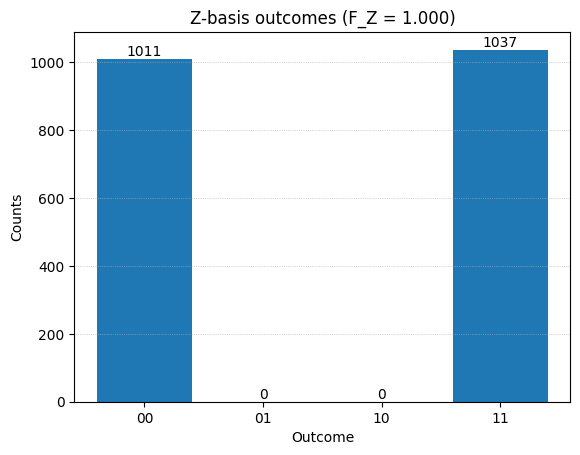

In [10]:
# Plot the observed results (only run this cell if the CHSH test passed!)
# F_Z is a simplified fidelity measure only considering the computational basis (it should be 1)

import matplotlib.pyplot as plt

# Get the counts of each possibly observed result 00, 01, 10, 11
counts = qunscious_result['experiment_result']['counts'] # type: ignore

# Choose a fixed label order for 2-qubit outcomes
labels = ['00', '01', '10', '11']
values = [counts.get(k, 0) for k in labels]

N = sum(values)
F_Z = (counts.get('00', 0) + counts.get('11', 0)) / N if N else float('nan')
title = f"Z-basis outcomes (F_Z = {F_Z:.3f})"

fig, ax = plt.subplots()
bars = ax.bar(labels, values)
ax.set_title(title)
ax.set_xlabel("Outcome")
ax.set_ylabel("Counts")
ax.set_ylim(bottom=0)
ax.grid(True, axis='y', linestyle=':', linewidth=0.5)

# Add labels on top of each bar
for bar, value in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(value),
        ha='center', va='bottom'
    )
plt.show()